In [1]:
import pandas as pd
import json
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

### Leitura do arquivo

No Firebase os dados encontram-se ordenados como estruturas aninhadas. Vamos usar a função Export JSON no Firebase console.

<img src=firebase_object_tree.png width=200>


A função *Exportar o JSON* fica à direita na visão de base de dados:
<img src=export_json.png width=500>

In [2]:
arquivo = open("teste-ab-export.json")
linhas = arquivo.readlines()
texto = "".join(linhas)
dados_fire = json.loads(texto)

### Análise do atributo logs

 Veja que log, que contém todos os dados, está pesadamente aninhado

In [4]:
for k,v in dados_fire["borbamartim-cd-351f6"].items():
    # print(k,v) # habilite para imprimir as chaves de mais alto nível
    for chave, valor in v.items():
        # print(chave, valor) # habilite para imprimir as chaves inferiores
        pass # desabilite quando reabilitar a linha de cima



### Convertendo para um dataframe

O pandas entende listas de dicionários que têm as mesmas chaves. O Firebase nos dá dicionários de dicionários de dicionários. 

Vamos precisar converter. Basta inserir todos os itens que estavam na chave "logs" em uma lista

In [6]:
lista_dicionarios = []

for k,v in dados_fire["borbamartim-cd-351f6"].items():
    lista_dicionarios.append(v)

        


A função `from_records` converte a lista de dicionários em um dataframe

In [7]:
dataframe = pd.DataFrame.from_records(lista_dicionarios)

Desta forma temos o dataframe. Observe que os eventos são dos seguintes tipos:

* *inicio* - quando um usuário inicia uma tarefa
* final - quando o usuário termina uma tarefa

Precisamos agrupar pelo `id` do usuário e depois subtrair o tempo inicial do final, para sabermos quanto tempo efetivamente levou aquela tarefa

In [8]:
dataframe

,tempo,tipo,user_id,versao
0,1478022590256,inicio,1355150594,A
1,1478022603004,final,1355150594,A


### Convertendo para um DataFrame de delta_t

In [9]:
agrupado = dataframe.groupby(by=["user_id", "versao"])

In [10]:
users = set(dataframe.user_id) # We convert it to a set so that each user appear only once

In [11]:
users = list(users) 

In [12]:
resultados = []

for u in users:
    for versao in ["A", "B"]:
        if (u, versao) in agrupado.groups.keys(): # Check if a specific pair user/type of test happened
            grupo1 =  agrupado.get_group((u, versao))
            grupo1 = grupo1.sort_values(by="tempo") # Para evitar que inícios sem fim gerem tempos negativos
            
            if len(grupo1[grupo1.tipo=="final"])>= 1 and len(grupo1[grupo1.tipo=="inicio"]) >= 1:
                delta_t = grupo1[grupo1.tipo=="final"].iloc[-1].tempo - grupo1[grupo1.tipo=="inicio"].iloc[0].tempo
                resultados.append({"user_id":u, "delta_t":delta_t, "versao":versao})

In [13]:
grupo1.sort_values(by="tempo")

,tempo,tipo,user_id,versao
0,1478022590256,inicio,1355150594,A
1,1478022603004,final,1355150594,A


In [14]:
dataframe_resumo = pd.DataFrame.from_records(resultados)

In [15]:
dataframe_resumo.delta_t/=1000 # Convertendo milissegundos em segundos

In [16]:
dataframe_resumo

,delta_t,user_id,versao
0,12.748,1355150594,A


# Comparação dos histogramas

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

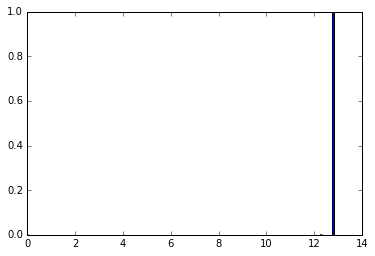

In [17]:
tempos_A = list(dataframe_resumo[dataframe_resumo.versao=="A"].delta_t)
tempos_B = list(dataframe_resumo[dataframe_resumo.versao=="B"].delta_t)
plt.hist(tempos_A, bins=10)
plt.hist(tempos_B, bins=10, alpha=0.5)